![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 8 - Auto-encoder </center>
### <center> Credit Card </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex8/Exercise08_AE.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchinfo

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex8/DeepLearningFramework ./DeepLearningFramework

### Exercise:
Use a combined classifier and AE to obtain high AUC score.
* A stand alone classifier can obtained about 98 AUC score.
* A stand alone AE can obtained about 96 AUC score.
* Combining the two should (slightly) improve the results.

#### Load the data:

In [5]:
dData = pd.read_csv('../../../data/creditcard.csv')
dData

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


#### Normalize the data:

In [6]:
mX = dData.drop(columns=['Class']).values
vY = dData['Class']               .values

mX[:,[0,-1]] -= mX[:,[0,-1]].mean(0)
mX[:,[0,-1]] /= mX[:,[0,-1]].std (0)

mX = torch.tensor(mX, dtype=torch.float32)
vY = torch.tensor(vY, dtype=torch.float32)
N  = mX.shape[0]

mX.shape, vY.shape

(torch.Size([284807, 30]), torch.Size([284807]))

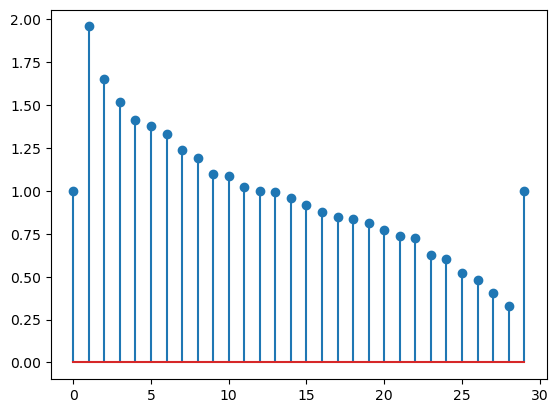

In [7]:
plt.stem(mX.std(dim=0).numpy())
plt.show()

#### Unbalanced data:

In [8]:
1 - vY.mean()

tensor(0.9983)

In [9]:
(vY == 0).sum() / (vY == 1).sum()

tensor(577.8760)

#### Dataset:

In [10]:
from torch.utils.data import TensorDataset, DataLoader, random_split

oDataset            = TensorDataset(mX, vY)
nTrain              = 200000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest], generator=torch.Generator().manual_seed(6))

In [11]:
vX, y = oTrainSet[0]
vX.shape, y

(torch.Size([30]), tensor(0.))

#### Data-loader:

In [12]:
from torch.utils.data import DataLoader

batchSize = 1024
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = DataLoader(oTestSet,  shuffle=True,  batch_size=2*batchSize)

mX,       vY = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([1024, 30]), torch.Size([1024]))

#### Model #1 - FC

In [13]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()

        self.oNN = nn.Sequential(
            nn.Linear(30,  128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(128, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1), nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Flatten(start_dim=0)
        )                  

    def forward(self, mX):
        return self.oNN(mX)
            
torchinfo.summary(FC(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
FC                                       --                        --
├─Sequential: 1-1                        [1024]                    --
│    └─Linear: 2-1                       [1024, 128]               3,968
│    └─BatchNorm1d: 2-2                  [1024, 128]               256
│    └─LeakyReLU: 2-3                    [1024, 128]               --
│    └─Dropout: 2-4                      [1024, 128]               --
│    └─Linear: 2-5                       [1024, 128]               16,512
│    └─BatchNorm1d: 2-6                  [1024, 128]               256
│    └─LeakyReLU: 2-7                    [1024, 128]               --
│    └─Dropout: 2-8                      [1024, 128]               --
│    └─Linear: 2-9                       [1024, 128]               16,512
│    └─BatchNorm1d: 2-10                 [1024, 128]               256
│    └─LeakyReLU: 2-11                   [1024, 128]               --
│

In [14]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU
    lY          = []
    lHatY       = []


    oModel.train(bTrain) #-- train or test
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            vHatY = oModel(mX)
            loss  = Loss  (vHatY, vY)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                vHatY = oModel(mX)
                loss  = Loss  (vHatY, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = vY.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            lY          += [vY]
            lHatY       += [vHatY]
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    vY    = torch.cat(lY)
    vHatY = torch.cat(lHatY)
        
    print('', end='\r')
    epochLoss   /= count
    epochMetric  = Metric(vHatY, vY)

    return epochLoss, epochMetric, vLR
#     return epochLoss, -epochLoss, vLR

In [15]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import AUC, BinaryAcuuracy
from DeepLearningFramework.Losses   import LabelSmoothingLoss

DEVICE = torch.device        ("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2))
Metric = AUC                 ()

#### Train the FC
AUC score should be about 97-98.

In [16]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oFC        = FC         ().to(DEVICE)
oOptim     = optim.AdamW(oFC.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1e-2)
oScheduler = OneCycleLR (oOptim, max_lr=1e-4, total_steps=nIter)
lHistory   = TrainModel (oFC, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='FC')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.708 | Val loss:  0.632 | Train Metric:  0.485 | Val Metric:  0.918 | epoch time:  2.297 | <-- Checkpoint!
Epoch 001: | Train loss:  0.526 | Val loss:  0.413 | Train Metric:  0.881 | Val Metric:  0.946 | epoch time:  2.269 | <-- Checkpoint!
Epoch 002: | Train loss:  0.281 | Val loss:  0.199 | Train Metric:  0.930 | Val Metric:  0.945 | epoch time:  2.232 |
Epoch 003: | Train loss:  0.136 | Val loss:  0.093 | Train Metric:  0.917 | Val Metric:  0.954 | epoch time:  2.242 | <-- Checkpoint!
Epoch 004: | Train loss:  0.070 | Val loss:  0.051 | Train Metric:  0.934 | Val Metric:  0.959 | epoch time:  2.236 | <-- Checkpoint!
Epoch 005: | Train loss:  0.040 | Val loss:  0.031 | Train Metric:  0.932 | Val Metric:  0.963 | epoch time:  2.234 | <-- Checkpoint!
Epoch 006: | Train loss:  0.026 | Val loss:  0.022 | Train Metric:  0.950 | Val Metric:  0.

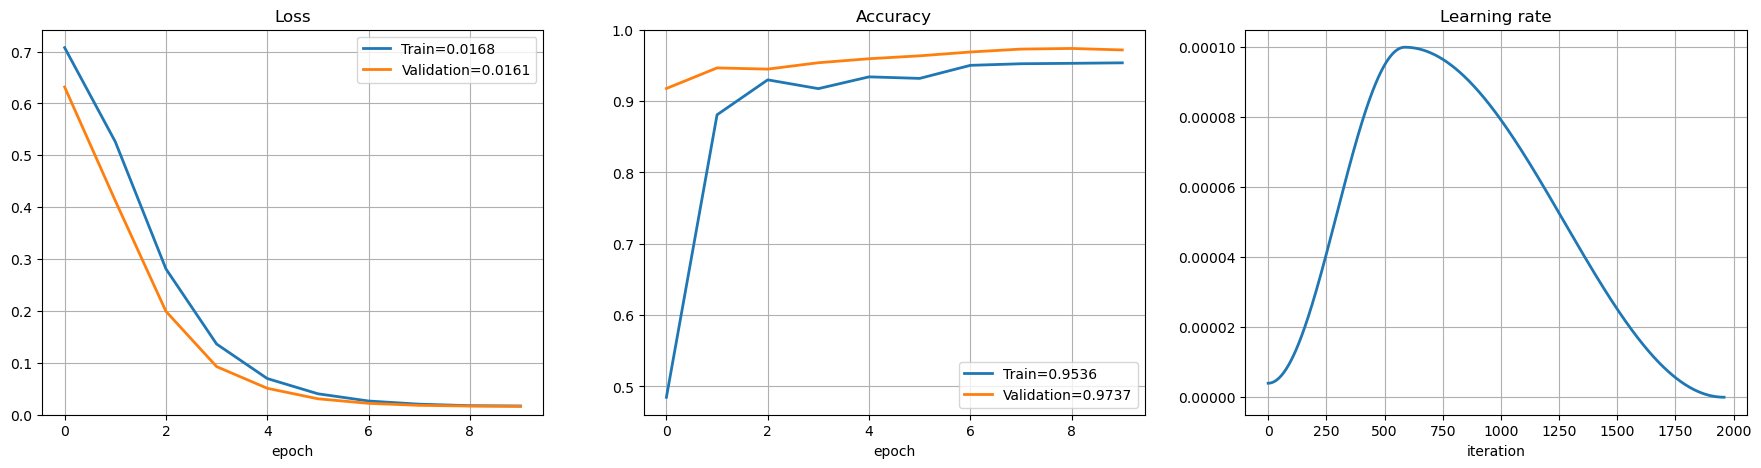

In [17]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

#### Model #2 - AE
Implement the AE.  
You can make it using a single `nn.Sequential` since we do not need the latent space.

In [16]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.oNN = nn.Sequential(
            ???
        )                  

    def forward(self, mX):
        return self.oNN(mX)
            
torchinfo.summary(AE(), mX.shape)

SyntaxError: invalid syntax (<ipython-input-16-7381c8253540>, line 5)

#### Fill the missing `???`

In [19]:
def EpochAE(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU
    lY          = []
    lHatY       = []


    oModel.train(bTrain) #-- train or test
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mHatX = oModel(mX)
            loss  = ???
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mHatX = oModel(mX)
                loss  = ???

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = vY.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            lY          += [vY]
            lHatY       += [nn.MSELoss(reduction='none')(mHatX, mX).sum(1)]
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    vY    = torch.cat(lY)
    vHatY = torch.cat(lHatY)
        
    print('', end='\r')
    epochLoss   /= count
    epochMetric  = Metric(vHatY, vY)

    return epochLoss, epochMetric, vLR

In [20]:
Loss   = ???
Metric = AUC       ()

#### Train the AE
AUC score should be about 96-97.

In [21]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oAE        = AE         ().to(DEVICE)
oOptim     = ???
oScheduler = ???
lHistory   = TrainModel (oAE, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=EpochAE, sModelName='AE')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  1.208 | Val loss:  1.118 | Train Metric:  0.944 | Val Metric:  0.958 | epoch time:  2.528 | <-- Checkpoint!
Epoch 001: | Train loss:  1.026 | Val loss:  0.865 | Train Metric:  0.947 | Val Metric:  0.959 | epoch time:  2.516 | <-- Checkpoint!
Epoch 002: | Train loss:  0.786 | Val loss:  0.654 | Train Metric:  0.951 | Val Metric:  0.961 | epoch time:  2.512 | <-- Checkpoint!
Epoch 003: | Train loss:  0.630 | Val loss:  0.549 | Train Metric:  0.955 | Val Metric:  0.962 | epoch time:  2.544 | <-- Checkpoint!
Epoch 004: | Train loss:  0.544 | Val loss:  0.485 | Train Metric:  0.956 | Val Metric:  0.960 | epoch time:  2.519 |
Epoch 005: | Train loss:  0.494 | Val loss:  0.446 | Train Metric:  0.955 | Val Metric:  0.958 | epoch time:  2.514 |
Epoch 006: | Train loss:  0.467 | Val loss:  0.422 | Train Metric:  0.954 | Val Metric:  0.955 | epoch time

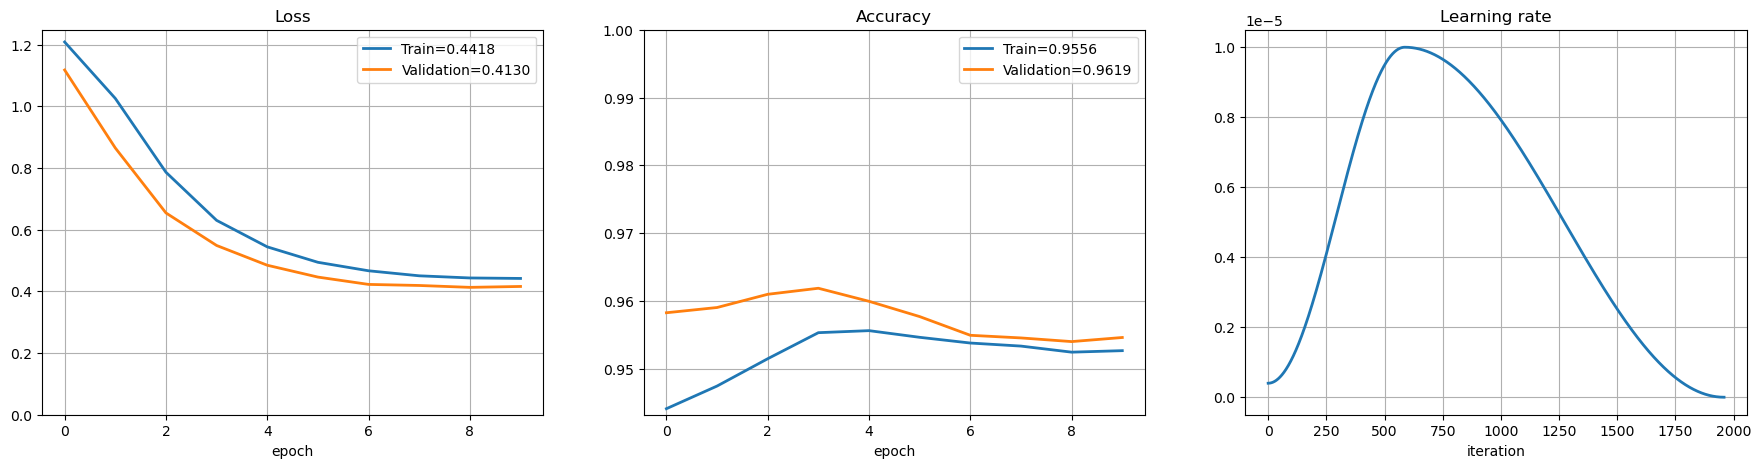

In [22]:
PlotHistory(lHistory)
plt.show   ()

#### Outlier score
Given $f_{\mathrm{AE}}$, an auto-encoder,  
the outlier score is given by:
$$\text{score}=\left\Vert f_{\mathrm{AE}}\left(\boldsymbol{x}\right)-\boldsymbol{x}\right\Vert _{2}^{2}$$

In [23]:
def OutlierScore(oAE, mX):
    #-- mX    .shape = (N, D)
    #-- vScore.shape = (N,)
    vScore = ???
    return vScore

#### Get the scores from both models to the entire (test) dataset:

In [24]:
lTestY  = []
lScore1 = []
lScore2 = []
with torch.no_grad():
    for (mX, vY) in oTestDL:
        mX        = mX.to(DEVICE)
        vScore1   = oFC(mX)
        vScore2   = OutlierScore(oAE, mX)
        lTestY   += [vY]
        lScore1  += [vScore1]
        lScore2  += [vScore2]
    
vTestY  = torch.cat(lTestY) .cpu().numpy()
vScore1 = torch.cat(lScore1).cpu().numpy()
vScore2 = torch.cat(lScore2).cpu().numpy()

#### The AUC score of each model (separately):

In [25]:
from sklearn.metrics import roc_auc_score

print(f'FC model AUC = {roc_auc_score(vTestY, vScore1):.5f}')
print(f'AE model AUC = {roc_auc_score(vTestY, vScore2):.5f}')

FC model AUC = 0.97374
AE model AUC = 0.96186


#### Finding $\alpha$, the optimal linear combination of the two scores:

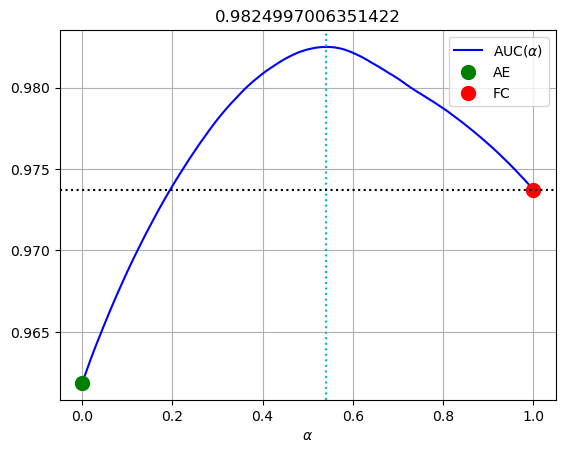

In [26]:
from sklearn.preprocessing import StandardScaler

vScore1 = StandardScaler().fit_transform(vScore1[:,None])[:,0]
vScore2 = StandardScaler().fit_transform(vScore2[:,None])[:,0]

K       = 101
v       = np.linspace(0, 1, K)
vAUC    = np.zeros   (K)

for ii in range(K):
    vScore   = v[ii] * vScore1 + (1 - v[ii]) * vScore2
    vAUC[ii] = roc_auc_score(vTestY, vScore)

idx = np.argmax(vAUC)
    
plt.plot   (v, vAUC,     'b',         label=r'AUC($\alpha$)')
plt.plot   (0, vAUC[0] , '.g', ms=20, label=r'AE')
plt.plot   (1, vAUC[-1], '.r', ms=20, label=r'FC')
plt.title  (f'{vAUC[idx]}')
plt.axvline(v[idx],   c='c', ls=':')
plt.axhline(vAUC[-1], c='k', ls=':')
plt.xlabel (r'$\alpha$')
plt.legend ()
plt.grid   ()
plt.show   ()